# Using Cassiopeia with spatial genomics

Cassiopeia can be used to analyze spatially-resolved lineage-tracing data.

As first described in Jones, Sun et al, there are several nuances that should be taken into account for spatial data, including:
* Resolution: often times, each "spot" observed in spatial data contains potentially multiple cells. For this reason, care should be taken to not remove "conflicting" intBCs as in the typical workflows
* Sparsity: spatial assays are often less sensitive than traditional single-cell approaches

Cassiopeia now has special functionality to handle spatial data, including approaches to process this data as well as handle the sparsity and resolution issues. In this tutorial, we discuss how one can reconstruct trees from spatial data after preprocessing using the pipeline described in the [preprocess.ipynb](./preprocess.ipynb) notebook tutorial.

We will begin with an example dataset from our recent KP-Spatial study.

In [69]:
import warnings

import anndata
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import squidpy as sq

import pyvista as pv
pv.set_jupyter_backend('trame')



In [2]:
allele_table = pd.read_csv('data/spatial_allele_table.txt', sep='\t')
allele_table = allele_table[~allele_table[['r1', 'r2', 'r3']].isna().any(axis=1)]

indel_priors = pd.read_csv("data/allele_priors.tsv", sep='\t', index_col = 0)
indel_colors = cas.pl.utilities.get_indel_colors(indel_priors, np.random.RandomState(1234))

adata = anndata.read_h5ad('data/spatial_adata.h5ad')

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Before creating the character matrix, we can apply some filtering to the allele table and mark the spots that get filtered out due to
quality issues. These are spots we can potentially rescue with imputation downstream.

Here, we have stored values like PercentUncut (i.e., percent `0` character) and target site UMIs in the anndata. You can draw these values from the allele table or compute them yourself and store them separately. We are not filtering on percent uncut, but we will remove spots with poor UMI support and try to rescue them later.

In [3]:
overlapping_cells = np.intersect1d(
    adata[adata.obs["TS-UMI"] >= 3].obs_names,
    allele_table["cellBC"].values,
)

pre_filtered_cells = np.intersect1d(adata.obs_names, allele_table["cellBC"].unique())
overlapping_cells = np.intersect1d(
    adata.obs_names,
    allele_table[allele_table["UMI"] >= 3]["cellBC"].unique(),
)
allele_table = allele_table[allele_table["cellBC"].isin(overlapping_cells)]

# create unimputed character matrix
(
    character_matrix,
    priors,
    state_to_indel,
) = cas.pp.convert_alleletable_to_character_matrix(
    allele_table,
    mutation_priors=indel_priors,
    collapse_duplicates=False,
    allele_rep_thresh=0.98,
)

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTCTTCGTAGTGr1']


Processing characters:   0%|          | 0/32 [00:00<?, ?it/s]

In [4]:
for character in state_to_indel:
    state_to_indel[character][-1] = np.nan

Now that we have the character matrix, let's compute some simple statistics around drop out.

Mean dropout per spot: 0.75


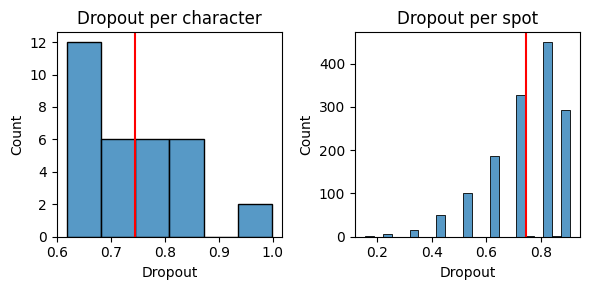

In [5]:
dropout_per_character = character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=0)
dropout_per_cell = character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=1)

print(f"Mean dropout per spot: {round(np.mean(dropout_per_cell), 2)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

sns.histplot(dropout_per_character, ax=ax1)
ax1.axvline(x = np.mean(dropout_per_character), color='red')
ax1.set_title("Dropout per character")
ax1.set_xlabel("Dropout")

sns.histplot(dropout_per_cell, ax=ax2)
ax2.axvline(x = np.mean(dropout_per_cell), color='red')
ax2.set_title("Dropout per spot")
ax2.set_xlabel("Dropout")

fig.tight_layout()
plt.show()

Let's add back in the cells pre-filtered to try and impute them.

In [6]:
# add in cells that did not have high-confidence target sites
missing_cells = np.setdiff1d(pre_filtered_cells, character_matrix.index)
print(f">> Adding back in {len(missing_cells)} cells for imputation.")
missing_cell_character_matrix = pd.DataFrame(
    np.zeros(
        (len(missing_cells), character_matrix.shape[1]), dtype=int
    ),
    index=missing_cells,
    columns=character_matrix.columns,
)
missing_cell_character_matrix.to_numpy().fill(-1)
character_matrix = pd.concat(
    [character_matrix, missing_cell_character_matrix]
)

>> Adding back in 3465 cells for imputation.


In [7]:
imputed_character_matrix = cas.sp.impute_spatial_data(
    character_matrix,
    adata,
    neighborhood_radius=30.0,
    imputation_hops = 2,
    num_imputation_iterations = 5
)

>> Imputation round 1...


100%|██████████| 145093/145093 [00:03<00:00, 39398.77it/s]


>> Imputation round 2...


100%|██████████| 133388/133388 [00:03<00:00, 44289.98it/s]


>> Imputation round 3...


100%|██████████| 127022/127022 [00:02<00:00, 47820.91it/s]


>> Imputation round 4...


100%|██████████| 123538/123538 [00:02<00:00, 50189.03it/s]


>> Imputation round 5...


100%|██████████| 121665/121665 [00:02<00:00, 51263.40it/s]


In [8]:
# remove spots with no information

imputed_character_matrix = imputed_character_matrix[
    (
        (imputed_character_matrix == -1).sum(axis=1)
        / imputed_character_matrix.shape[1]
    )
    < 1.0
]


Mean dropout per spot after imputation: 0.75 --> 0.61


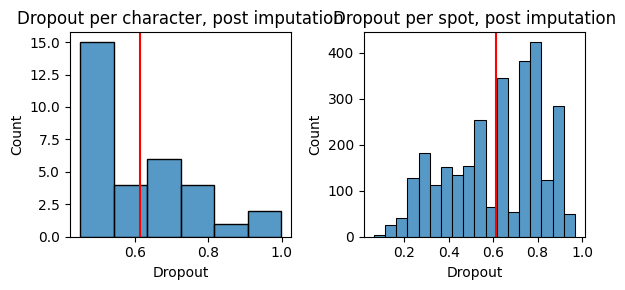

In [9]:
imputed_dropout_per_character = imputed_character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=0)
imputed_dropout_per_cell = imputed_character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=1)

print(f"Mean dropout per spot after imputation: "
    f"{round(np.mean(dropout_per_cell), 2)} --> {round(np.mean(imputed_dropout_per_cell), 2)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

sns.histplot(imputed_dropout_per_character, ax=ax1)
ax1.axvline(x = np.mean(imputed_dropout_per_character), color='red')
ax1.set_title("Dropout per character, post imputation")
ax1.set_xlabel("Dropout")

sns.histplot(imputed_dropout_per_cell, ax=ax2)
ax2.axvline(x = np.mean(imputed_dropout_per_cell), color='red')
ax2.set_title("Dropout per spot, post imputation")
ax2.set_xlabel("Dropout")

fig.tight_layout()
plt.show()

Now that we have a character matrix, we can reconstruct lineages using one of several algorithms in the Cassiopeia package.

For simplicity, we'll reconstruct with the Vanilla Greedy algorithm:

In [10]:
vg_solver = cas.solver.VanillaGreedySolver()

tree = cas.data.CassiopeiaTree(character_matrix = imputed_character_matrix, priors=priors)
vg_solver.solve(tree)

tree.collapse_mutationless_edges(infer_ancestral_characters=True)


  0%|          | 0/2911 [00:00<?, ?it/s]

filling in multiindex table:   0%|          | 0/35629 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 17.77it/s]


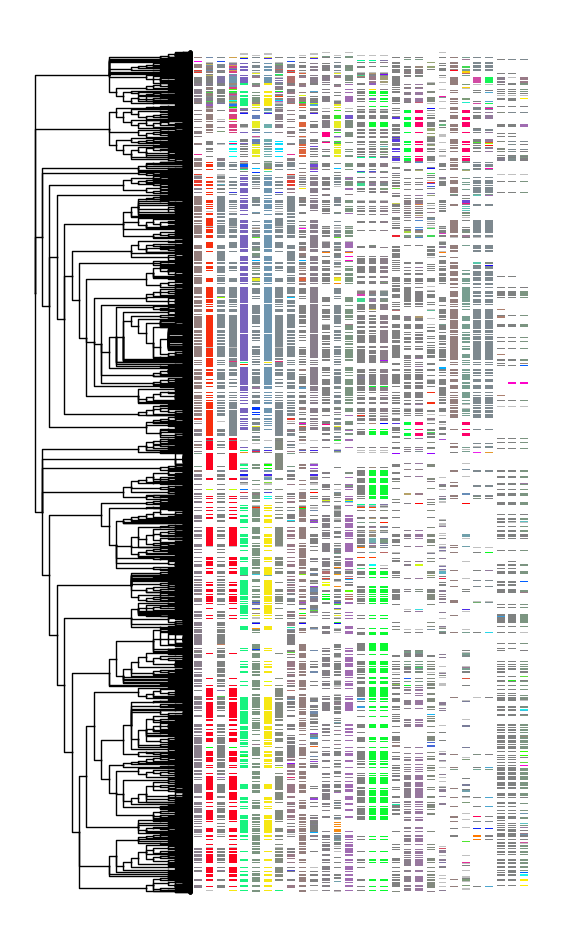

In [11]:
# create reconciled allele table for plotting
allele_table_to_plot = cas.pp.convert_character_matrix_to_allele_table(imputed_character_matrix, state_to_indel, keep_ambiguous=False)
allele_table_to_plot['r1'] = allele_table_to_plot['r1'].astype(str)

# filter out lowly abundant characters
percent_present = allele_table_to_plot.groupby('intBC').agg({'r1': len}) / allele_table_to_plot['cellBC'].nunique()
to_keep = percent_present[(percent_present.values > 0.15)].index

allele_table_filtered = allele_table_to_plot[allele_table_to_plot['intBC'].isin(to_keep)]
allele_table_filtered['intBC'].unique()

h = plt.figure(figsize=(7,12))
ax = plt.gca()
cas.pl.plot_matplotlib(
    tree,
    orient='right',
    allele_table=allele_table_filtered,
    add_root=False,
    figsize=(3.5, 6),
    indel_colors=indel_colors,
    ax=ax,
)
plt.show()

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


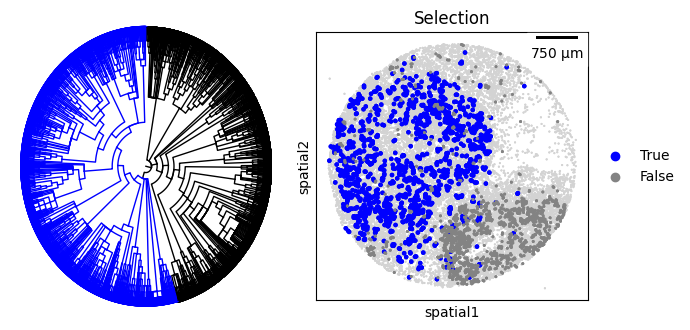

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


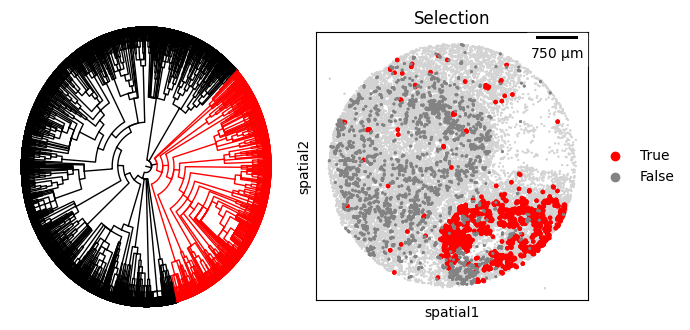

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


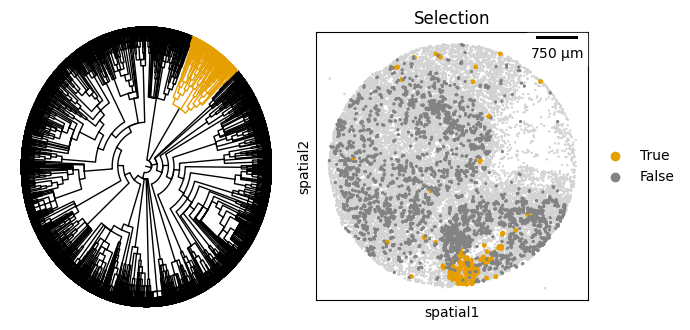

In [12]:
def plot_selection(tree, adata, node, color):
    
    subtree = tree.leaves_in_subtree(node)

    adata.obs['Selection'] = np.nan
    adata.obs.loc[tree.leaves, 'Selection'] = "False"
    adata.obs.loc[subtree, 'Selection'] = "True"
    
    with warnings.catch_warnings():

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
        cas.pl.plot_matplotlib(
            tree,
            add_root=True,
            indel_priors=None,
            clade_colors={node: color},
            ax=ax1
        )

        adata.uns['Selection_colors'] = ['#838383', color]
        adata.obs['library_id'] = 'puck1'

        sq.pl.spatial_scatter(adata, size=1, library_id='puck1', shape=None, na_color='lightgray', ax=ax2, figsize=(5,5), legend_loc=None)
        sq.pl.spatial_scatter(adata, color=['Selection'],
                            groups = ['True'],
                            library_id='puck1',
                            size=20, ax=ax2, shape=None,
                                scalebar_dx=1.0,
                            scalebar_units='um',
                            scalebar_kwargs={"scale_loc": "bottom", "location": "upper right"})

        sq.pl.spatial_scatter(adata, color=['Selection'], library_id='puck1',
                            groups = ['False'],
                            size=5, ax=ax2, shape=None)


        fig.tight_layout()
        plt.show()

node = tree.root
# find three largest subclades
sizes = np.array([len(tree.leaves_in_subtree(child)) for child in tree.children(node)])
iid = np.argsort(-sizes)[:3]

colors = ['blue', 'red', '#E69F00', '#D34818']
clade_to_colors = {}
for _iter, child in zip(range(3), np.array(tree.children(node))[iid]): 
    clade_to_colors[child] = colors[_iter]
    plot_selection(tree, adata, child, colors[_iter])


## Simulating spatial lineage data

Another key capability of the Cassiopeia spatial library is to simulate spatially-resolved data for the purposes of theoretical work and benchmarking of new algorithms. Below, we briefly walk through the basics of simulating trees. 

One can then take these simulated trees and fit them into any of the benchmarking code described in the [benchmark.ipynb](./benchmark.ipynb) tutorial.

In [29]:
# define lineage tracing data parameters

number_of_cassettes = 39
size_of_cassette = 1

# Specify the mutation proportion
mutation_proportion = 0.5
get_mutation_rate= lambda depth: -np.log2(1-mutation_proportion)/depth

number_of_states = 100
state_generating_distribution = lambda: np.random.exponential(1e-5)

# Specify the dropout proportions. Note that the heritable missing data proportion will be
# total_dropout_proportion - stochastic_proportion
total_dropout_proportion = 0.0
stochastic_proportion = 0.0
heritable_proportion = total_dropout_proportion - stochastic_proportion

get_heritable_rate = lambda depth: -np.log2(1-heritable_proportion)/depth

Below we set up three simulators:

1. A `BirthDeathFitnessSimulator` that simulates a tree topology according to user-specified birth and death rates.
2. A `LineageTracingDataSimulator`, specifically a `Cas9LineageTracingDataSimulator` that deposits edits along a tree according to the principles of a Cas9 tracer.
3. A `ClonalSpatialDataSimulator` that overlays spatial coordinates on the reconstructed tree. We define an arbitrary cube of unit coordinates

In [61]:
tree_simulator = lambda num_extant: cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution = lambda scale: np.random.lognormal(mean = np.log(scale),sigma = .5),
    initial_birth_scale = 1,
    death_waiting_distribution = lambda: np.random.uniform(0,4),
    mutation_distribution = lambda: 1,
    fitness_distribution = lambda: np.random.normal(0, .25),
    fitness_base = 1,
    num_extant = num_extant)

lt_simulator = lambda depth: cas.simulator.Cas9LineageTracingDataSimulator(
    number_of_cassettes = number_of_cassettes,
    size_of_cassette = size_of_cassette,
    mutation_rate = get_mutation_rate(depth),
    number_of_states=number_of_states,
    state_generating_distribution=state_generating_distribution,
    heritable_silencing_rate=get_heritable_rate(depth),
    stochastic_silencing_rate=stochastic_proportion,
    collapse_sites_on_cassette=True)

shape = (1,1)
spatial_simulator = cas.sim.ClonalSpatialDataSimulator(shape=shape,)

Now we'll simulate the data - first the tree, then the lineage data, and then finally the spatial data. We'll end by sampling randomly leaves.

In [85]:
np.random.seed(1234678)

tree = tree_simulator(4000).simulate_tree()
lt_simulator(tree.get_mean_depth_of_tree()).overlay_data(tree)
spatial_simulator.overlay_data(tree)
tree = cas.sim.UniformLeafSubsampler(ratio = .25).subsample_leaves(tree)

# relabel nodes
node_map = {l: f'cell{l}' for l in tree.leaves}
tree.relabel_nodes(node_map)
tree.character_matrix.index = [f'cell{l}' for l in tree.character_matrix.index]
tree.cell_meta.index = tree.cell_meta.index.map(node_map)

tree.collapse_unifurcations()

  0%|          | 0/1000 [00:00<?, ?it/s]

filling in multiindex table:   0%|          | 0/39000 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:00<00:00, 41.77it/s]


(<Figure size 300x450 with 1 Axes>, <Axes: >)

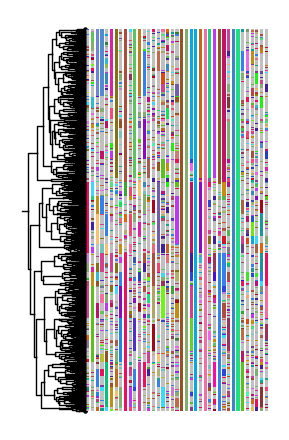

In [77]:
allele_table = cas.pp.convert_character_matrix_to_allele_table(tree.character_matrix.astype(int))

cas.pl.plot_matplotlib(tree, orient='right',
                       allele_table=allele_table.astype(str),
                       # indel_priors=priors_df,
                       figsize=(3, 4.5),
                       extend_branches = False)

In [92]:
simulated_adata = anndata.AnnData(obs=pd.DataFrame(index=tree.leaves))
simulated_adata.obs['library_id'] = 'simulated_puck'

simulated_adata.obsm['spatial'] = tree.cell_meta[['spatial_0', 'spatial_1']].to_numpy()

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


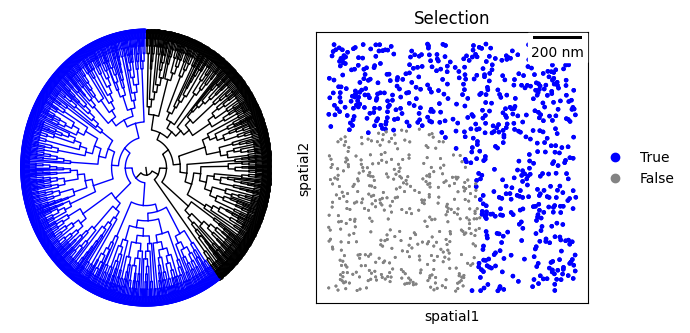

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


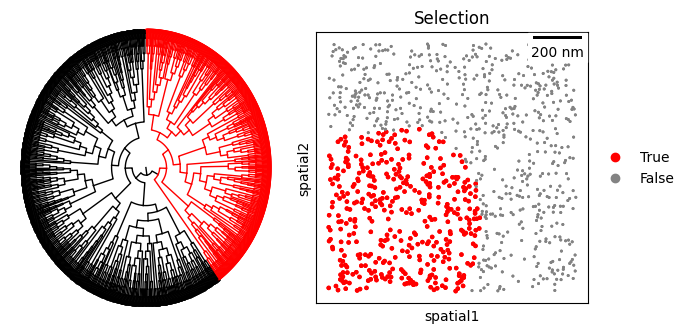

In [99]:
node = tree.root

# find three largest subclades
sizes = np.array([len(tree.leaves_in_subtree(child)) for child in tree.children(node)])
iid = np.argsort(-sizes)[:3]

colors = ['blue', 'red', '#E69F00', '#D34818']
clade_to_colors = {}
for _iter, child in zip(range(3), np.array(tree.children(node))[iid]): 
    clade_to_colors[child] = colors[_iter]
    plot_selection(tree, simulated_adata, child, colors[_iter])
